## Introduction

In this notebook I will be investigating the bahviour of a simple model of ENSO oscillations. The model, due to [Jin (1996)](#References) is based 

In [1]:
# Import everything needed to demonstrate ENSO oscillator.
from __future__ import division, print_function

import numpy as np

import ensosim as sim
from ensoplot import plot_output, clear_plots, plot_ensemble_output
import pylab as plt
%matplotlib inline

In [2]:
# Calculate some periods. All values passed into enso_oscillator(...) are non-dimensionalised
# first and all output is also non-dimensionalised (so needs redimensionalising before e.g.
# plotting).
omega_c = np.sqrt(3/32)
tau_c = 2 * np.pi / omega_c
one_period = tau_c
five_periods = one_period * 5
print('one period: {}'.format(one_period * sim.TIME_SCALE))
nt = 10000

one period: 41.0415945652


In [3]:
settings = sim.init_settings()
sim.print_settings(settings, ['T0', 'h0', 'mu0', 'b0', 'gamma', 'c', 'r', 'alpha'])

T0: 0.15
h0: 0.0
mu0: 0.666666666667
b0: 2.5
gamma: 0.75
c: 1
r: 0.25
alpha: 0.125


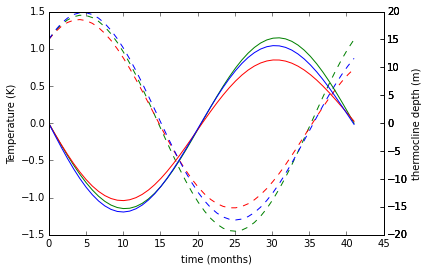

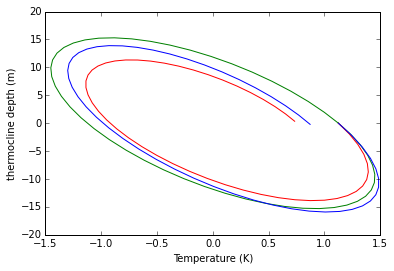

In [4]:
settings = sim.init_settings()
nt = 50
plot_output(*sim.enso_oscillator(one_period, nt, **settings), colour='g')
settings['scheme'] = 'bt'
plot_output(*sim.enso_oscillator(one_period, nt, **settings), colour='r', clear=False)
settings['scheme'] = 'ft'
plot_output(*sim.enso_oscillator(one_period, nt, **settings), colour='b', clear=False)

setting: mu0=0.66, 
setting: mu0=0.67, 


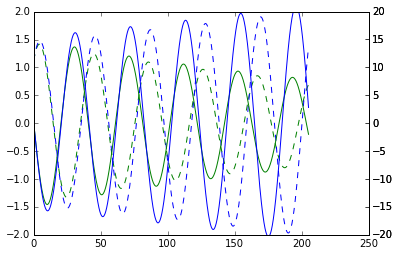

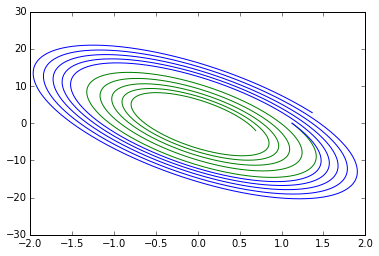

In [5]:
nt = 10000
settings = sim.init_settings(mu0=0.66)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='g', clear=False)

settings = sim.init_settings(mu0=0.67)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='b', clear=False)

setting: epsilon=0.1, 


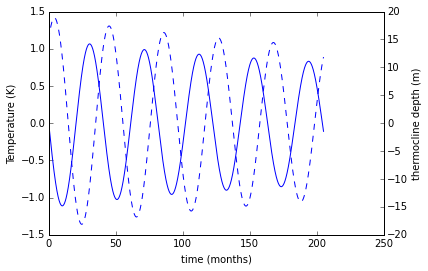

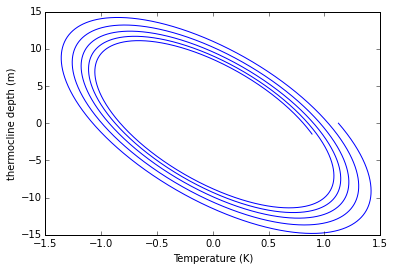

In [6]:
settings = sim.init_settings(epsilon=0.1)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings))

setting: epsilon=0.1, mu0=0.67, 


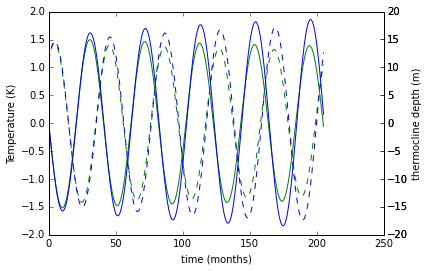

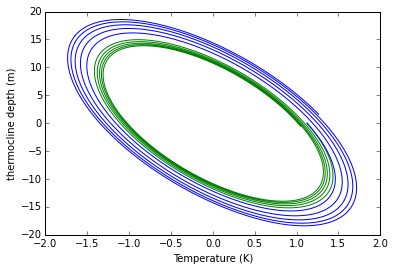

In [7]:
settings = sim.init_settings(epsilon=0.1, mu0=0.67)
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='g')
settings['mu0'] = 0.675
plot_output(*sim.enso_oscillator(five_periods, nt, **settings), colour='b', clear=False)

setting: mu_ann=0.2, epsilon=0.1, mode=annual_cycle, mu0=0.75, tau=6.0, 


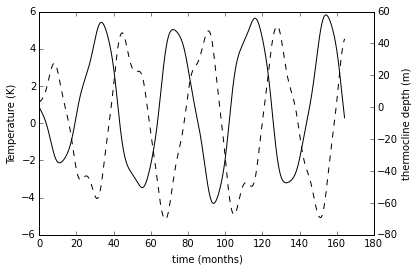

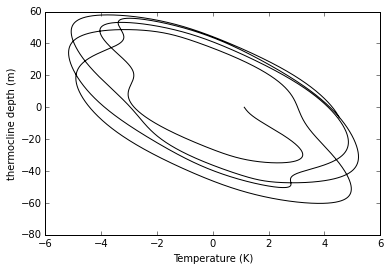

In [8]:
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
settings = sim.init_settings(epsilon=0.1, mu0=0.75, mu_ann=0.2, tau=tau,
                             mode='annual_cycle')
plot_output(*sim.enso_oscillator(one_period * 4, nt, **settings), ylim=(-80, 60), colour='k')

setting: tau=6.0, mu0=0.75, mu_ann=0.2, epsilon=0.1, tau_cor=0.0166666666667, f_ran=0.2, mode=annual_cycle, f_ann=0.02, 


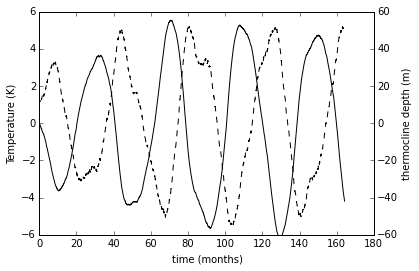

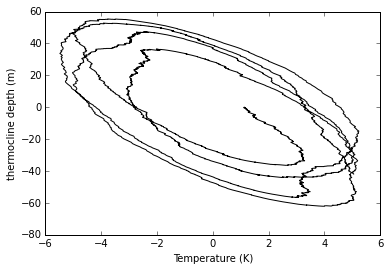

In [9]:
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
tau_cor=1/30/sim.TIME_SCALE # N.B. non-dimensionalised
settings = sim.init_settings(epsilon=0.1, mu0=0.75, mu_ann=0.2, tau=tau,
                             f_ann=0.02, f_ran=0.2, tau_cor=tau_cor,
                             mode='annual_cycle')
plot_output(*sim.enso_oscillator(one_period * 4, nt, **settings), ylim=(-60, 60), colour='k')

setting: tau=6.0, mu0=0.75, mu_ann=0.2, epsilon=0.1, tau_cor=0.0166666666667, f_ran=0.2, mode=annual_cycle, debug=False, f_ann=0.02, 
-0.05, -0.045, -0.04, -0.035, -0.03, -0.025, -0.02, -0.015, -0.01, -0.005, 0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 

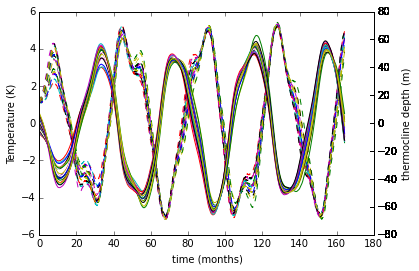

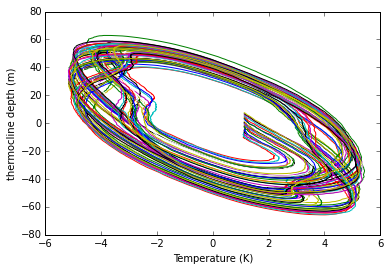

In [10]:
nperiods = 4
# Set dt to one day by calculating nt correspondingly.
nt = int(one_period * nperiods * 30)
tau=12/sim.TIME_SCALE # N.B. non-dimensionalised
tau_cor=1/30/sim.TIME_SCALE # N.B. non-dimensionalised

results = sim.run_enso_ensemble(one_period * nperiods, nt, tau, tau_cor, 
                                h0_min=-0.05, h0_max=0.05)
plot_ensemble_output(results)

## References

Jin, F. F. (1996). Tropical ocean-atmosphere interaction, the Pacific cold tongue, and the El Niño-Southern Oscillation. Science, 274(5284), 76.